# Computing the oscillatory Cauchy operator

In [22]:
using ApproxFun, ApproxFunRational, ApproxFunOrthogonalPolynomials, ApproxFunFourier, Plots
# In the Julia REPL type "]" followed by "dev https://github.com/tomtrogdon/ApproxFunRational.jl"
# to install ApproxFunRational
# This will eventually be unified with RiemannHilbert.jl and SingularIntegralEquations.jl

In applications, many singular integral equations on $\mathbb R$ are of the form

$$
\begin{equation}
    u(s) - \begin{bmatrix} r_{11}(s)e^{i \alpha_{11} s }& r_{11}(s)e^{i \alpha_{12} s }\\
    r_{21}(s)e^{i \alpha_{21} s } & r_{22}(s)e^{i \alpha_{22} s } \end{bmatrix} \mathcal C_{\mathbb R}^- u(s) = \begin{bmatrix} b_{1}(s)e^{i \alpha_{1} s }\\
    b_{2}(s)e^{i \alpha_{2} s } \end{bmatrix}
\end{equation}
$$

where $u : \mathbb R \to \mathbb C^{1 \times 2}$.

* These usually arise as the singular integral reformulation of a Riemann-Hilbert or Weiner-Hopf problem.

* If all functions $r_{ij}$ and $b_j$ decay rapidly and the constants $\alpha_{ij}, \alpha_j$ are not too large, the methods we have developed so far can work.

* We will soon encounter situations where these restrictions do not hold and we then need to develop new methods to solve such an integral equation.  One approach uses a so-called "oscillatory Cauchy transform".

The package `ApproxFunFourier.jl` includes functionality to perform an expansion of a function in the basis (see also __[Weber 1980, Weideman 1995]__)

$$
\begin{equation}
    f(x) \approx \sum_{j=-N}^N c_j \left( \frac{ i + x}{i-x} \right)^j =: \mathcal R_Nf(x).
\end{equation}
$$

From __[TT 2014]__

$$
\|\mathcal R_N f - f\|_{H^t(\mathbb R)} \leq \left[ C_{\epsilon,s} N^{1 + \epsilon - s} + C_{s,t} N^{t -s} \right] \|f \circ M \|_{H^s(\mathbb T)}, \epsilon > 0, ~ t< s, ~ s > 1 + \epsilon.
$$


In [25]:
j = 3; f = x -> ((1im + x)/(1im - x))^j
F = Fun(f,Laurent(PeriodicLine()))
F.coefficients

6-element Array{Complex{Float64},1}:
  -5.898059818321144e-17 + 1.123463036421781e-16im 
  1.0563836956400109e-18 + 2.7519969431571108e-17im
  -3.535725968981903e-16 + 2.653370541853636e-17im 
 -1.0051183062408492e-16 - 7.051984705677992e-18im 
 -1.0303731760112273e-16 - 2.4004036653120646e-16im
                     1.0 + 4.254140085140859e-16im 

In [ ]:
j = -1; f = x -> ((1im + x)/(1im - x))^j
F = Fun(f,Laurent(PeriodicLine()))
F.coefficients

This expansion is computed by sampling $f$ at a set of points $x_0,x_1,\ldots,x_{2N}$ (evenly spaced on $[0,2\pi)$ and then mapped via an arctan transformation) and applying the fast Fourier transform to compute the coefficients.

Given
$$
\begin{equation}
    f(x) \approx \sum_{j=-N}^N c_j \left( \frac{ i + x}{i-x} \right)^j.
\end{equation}
$$
we can define the function
$$
\begin{equation}
    e^{i \alpha x} f(x) \approx \sum_{j=-N}^N c_j e^{i \alpha x} \left( \frac{ i + x}{i-x} \right)^j.
\end{equation}
$$
using `ApproxFunRational.jl`

In [26]:
f = x -> 1/(1 + x^2 + x^4); α = 2.
F = Fun(zai(f),OscLaurent(α)) # zai = zero at infinity
x = 1.; f(x)*exp(1im*α*x) - F(x)

2.7755575615628914e-17 - 1.6653345369377348e-16im

If we want to, instead, use the basis
$$
\begin{equation}
    f(x) \approx \sum_{j=-N}^N c_j \left( \frac{ Li + x}{Li-x} \right)^j.
\end{equation}
$$
for $L > 0$, we can:

In [27]:
j = -1; L = 2.; f = x -> ((1im*L+ x)/(1im*L - x))^j
F = Fun(f,OscLaurent(0.0,L)) # Or Laurent(PeriodicLine{false,Float64}(0.0.,L))
F.coefficients

4-element Array{Complex{Float64},1}:
 -2.7755575615628907e-17 + 3.061616997868383e-17im 
                     0.0 + 5.265055686820291e-17im 
                     1.0 - 1.1388289682557058e-16im
  2.7755575615628907e-17 + 3.061616997868383e-17im 

Now, if $f(\infty) = 0$ then we enforce
$$
\begin{equation}
    \sum_{j=-N}^N c_j ( -1)^j = 0
\end{equation}
$$
and we can write
$$
\begin{equation}
    f(x) \approx \sum_{j=-N}^N c_j \left [\left( \frac{ Li + x}{Li-x} \right)^j - (-1)^j \right].
\end{equation}
$$
And to keep consistent with other notation we write
$$
\begin{equation}
    f(x) \approx \sum_{j=-N}^N c_j (-1)^j \left [\left( \frac{ x + Li }{x - Li} \right)^j - 1 \right].
\end{equation}
$$

### The oscillatory Cauchy operator

The oscillatory Cauchy operator $\mathcal C_\alpha^{\pm}$ is defined to be
$$
\begin{equation}
    \mathcal C_\alpha^{\pm} f(x) = \lim_{\epsilon \downarrow 0}\frac{1}{2 \pi i} \int_{\mathbb R} e^{i \alpha x'} f(x') \frac{dx'}{x' - (x \pm i \epsilon)}, \quad \mathcal C^\pm := \mathcal C_0^\pm.
\end{equation}
$$

This leads naturally to the question of how to compute
$$
\begin{equation}
    \lim_{\epsilon \downarrow 0}\frac{1}{2 \pi i} \int_{\mathbb R} \underbrace{e^{i \alpha x'} \left[\left( \frac{ x' + Li }{x' - Li} \right)^j - 1 \right]}_{R_{-j,\alpha}(x'/L)}  \frac{dx'}{x' - (x \pm i \epsilon)}.
\end{equation}
$$
Note that $R_{j,\alpha}(x'/L)$ has a pole at $x' = i L\mathrm{sign}(j)$.

This is interesting question and it will lead us right back to orthogonal polynomials.

__From [TT 2013]__:  If $\alpha j \leq 0$ then
\begin{align*}
  \mathcal C^+ R_{j,\alpha}(x) &= \begin{cases}
    R_{j,\alpha}(x) & j > 0,
    \\ 0 & j < 0, \end{cases}\\
\mathcal C^- R_{j,\alpha}(x) &= \begin{cases} 0 & j > 0 \\ -R_{j,\alpha}(x) & j < 0.\end{cases}
\end{align*}
There exists a function $\eta_{j,n}(\alpha)$, $\alpha j > 0$ such that
\begin{align*}
\mathcal C^+ R_{j,\alpha}(x) & = \begin{cases} - \displaystyle \sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{n,0}(x) & j > 0,\\ 
R_{j,\alpha}(x) +  \displaystyle\sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{-n,0}(x) & j < 0, \end{cases}\\
\mathcal C^- R_{j,\alpha}(x) & = \begin{cases} -R_{j,\alpha}(x)-  \displaystyle\sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{n,0}(x) & j > 0,\\ 
  \displaystyle\sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{-n,0}(x) & j < 0. \end{cases}
\end{align*}

As a first attempt, the coefficients $\eta_{j,n}(\alpha)$ were written as a sum of hypergeometric functions after a pure residue calculation.  But after _some_ thought, one realizes that, for example, 
$$
\displaystyle \sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{n,0}(x)
$$
is a non-oscillatory function and the coefficients can be computed if the function itself can be computed on the appropriate grid $x_0,x_1,\ldots,x_{2N}$ (to then apply the fast Fourier transform).

\begin{align*}
\sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{\sigma n,0}(x) &=  r_{j,\alpha}\left(  \frac{-2 i \sigma L }{x + \sigma i L} \right) :=\mathrm{Res}\,\left\{ R_{j,\alpha}(x'/L) \frac{1}{x' - x} ; x' = -\sigma iL \right\} \\
&= \sum_{n = 1}^{|j|} \gamma_{j,n}(\alpha) \left( \frac{-2 i \sigma L }{x + \sigma i L} \right)^n, \sigma = \mathrm{sign}(j),
\end{align*}
where
\begin{align*}
\gamma_{j,n}(\alpha) = - e^{- |\alpha| L} L_{|j|-n}^{(n)}( 2 |\alpha| L)
\end{align*}
and  $L_{k}^{(\alpha)}(x)$ is the $k$th-order generalized Laguerre polynomial. We then use the well-known relation for Laguerre polynomials 
\begin{align*}
L_n^{(\alpha)}(x) = L_n^{(\alpha+1)}(x) - L_{n-1}^{(\alpha + 1)}(x)
\end{align*}
to obtain the recurrence relation for $j \geq 1$
\begin{align*}
  r_{j,\alpha}(z) = (1 + z) r_{j-1,\alpha}(z) + z e^{- |\alpha| L}( L_{j-1}^{(1)}(2 |\alpha| L) - L_{j-2}^{(1)}(2 |\alpha| L)), \quad z = \frac{-2 i \sigma L }{x + \sigma i L}.
\end{align*}

So, then the seemingly complicated sum takes the form:
\begin{align*}
  \sum_{j=1}^N c_j \sum_{n=1}^{j} \eta_{j,n}(\alpha) R_{\sigma n,0}(x) = \sum_{j=1}^N c_j r_{j,\alpha}(z)
\end{align*}
and if this is computed on the grid $x_0,x_1,\ldots,x_{2N}$ ( $O(N^2)$ flops because of the recurrence ) the fast Fourier transform will give the coefficients $d_j(\alpha)$ in the expansion
$$
\sum_{j=1}^N c_j r_{j,\alpha}(z) = \sum_{j = 1}^N d_j(\alpha) R_{\sigma j,\alpha}(x)
$$

In [29]:
f = x -> 1/(x + 2im) + exp(-x^2)
F = Fun(zai(f),OscLaurent(9.0,1.0))
𝓒⁺ = Cauchy(+1)
𝓒⁻ = Cauchy(-1)
@time (𝓒⁺*F)(.1)
@time (𝓒⁺*F)(.1) - (𝓒⁻*F)(.1) - F(.1)

  0.021005 seconds (18.33 k allocations: 1.279 MiB)
  0.018718 seconds (18.50 k allocations: 1.695 MiB)


0.0 + 0.0im

With sufficient decay, the relation
\begin{align*}
\lim_{z \to \pm i \infty} z\int_{\mathbb R} f(x') \frac{d x'}{x' -z} = -\int_{\mathbb R} f(x')d x'
\end{align*}
gives us the Fourier transform of $R_{j,0}(x)$:
\begin{align*}
 \int_{\mathbb R} e^{- i \alpha x'} R_{j,0}(x') {d x'} =  \begin{cases} - 4 \pi L e^{-|\alpha| L} L_{|j|-1}^{(1)}( 2 |\alpha| \sigma) & j \alpha > 0, \\
 -2 \pi |j| L & \alpha = 0,\\
 0 & j \alpha < 0, \end{cases}
\end{align*}
and a numerical method for computing Fourier transforms.

Note: From __[Webb & Iserles 2019]__ this implies that the basis $\{R_{j,0}\}$ has a skew-symmetric differentation matrix!

In [30]:
f = x -> 1/(x - 2im) + exp(-x^2)
F = Fun(zai(f),OscLaurent(2.0,1.0))
𝓕 = FourierTransform(-1.0)
(𝓕*F)(.1)

0.5885254797806003 + 0.09421998795110886im

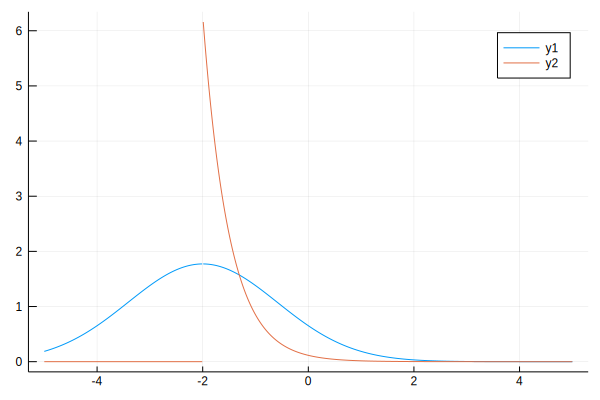

In [31]:
F̂ = 𝓕*F  # This uses Laguerre functionality in ApproxFunOrthogonalPolynomials.jl
ω = -5:.01:5
y = map(F̂,ω)
plot(ω,real(y))
plot!(ω,imag(y))